In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from datetime import datetime
import csv
from matplotlib import pyplot as plt
from sklearn.feature_extraction import text
import numpy as np
from gensim import matutils, models
import gensim
import seaborn as sns

#### Retrieve the preprocessed text data

In [9]:
import pickle

file_name = "N"

open_file = open(file_name, "rb")
data_lemmatized_N = pickle.load(open_file)
open_file.close()

# Document Term Matrix

#### Bad of Words approach

In [10]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized_N)
texts = data_lemmatized_N
corpus_new = [id2word.doc2bow(text) for text in texts] # BOW

# Topic Modeling with LDA

### Latent Dirichlet Allocation (LDA) Base Model

In [59]:
lda_10 = models.LdaModel(corpus=corpus_new, num_topics=10, id2word=id2word, passes=10)
lda_10.print_topics()

[(0,
  '0.122*"thing" + 0.055*"question" + 0.038*"issue" + 0.036*"point" + 0.030*"submit" + 0.030*"fact" + 0.025*"concern" + 0.024*"case" + 0.020*"moderator" + 0.015*"course"'),
 (1,
  '0.168*"time" + 0.036*"help" + 0.022*"week" + 0.019*"party" + 0.019*"idea" + 0.019*"text" + 0.019*"situation" + 0.017*"state" + 0.015*"race" + 0.014*"moment"'),
 (2,
  '0.069*"year" + 0.057*"post" + 0.050*"man" + 0.046*"action" + 0.042*"reason" + 0.035*"world" + 0.029*"woman" + 0.028*"story" + 0.022*"love" + 0.015*"item"'),
 (3,
  '0.048*"comment" + 0.029*"need" + 0.025*"submission" + 0.024*"user" + 0.023*"relationship" + 0.022*"job" + 0.021*"argument" + 0.019*"side" + 0.017*"example" + 0.016*"parent"'),
 (4,
  '0.130*"people" + 0.085*"way" + 0.043*"system" + 0.036*"lot" + 0.026*"part" + 0.019*"word" + 0.018*"end" + 0.016*"bit" + 0.016*"night" + 0.016*"resource"'),
 (5,
  '0.050*"character" + 0.038*"life" + 0.037*"music" + 0.036*"player" + 0.033*"money" + 0.027*"alignment" + 0.024*"content" + 0.020*"comp

By human interpretation, the result show us the possible topics that LDA can achieved and it looks decent, but we are unsure about the optimal number of topics, number of iteration and more just by human judgement. And most importantly, we couldnt't interpret the topics accurately just by observation. Therefore it is important to get a grasp on the parameters involved in LDA and perform fine tuning.

#### Coherence Score of Base Model
Ideally, we can train different LDA models by computing the coherence score of these models.

In [60]:
from gensim.models import CoherenceModel

# Compute Coherence Score for the base model
coherence_model_lda = CoherenceModel(model=lda_10, texts=data_lemmatized_N, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score for 10 topics: ', coherence_lda)


Coherence Score for 10 topics:  0.37482092764990943


The scores is not as good as we expected due to multiple reason. 
- We don't know the optimal number of topics that can give the best result
- We don't know the alpha and beta values that give the best result

### Hyperparameter tuning

From a standard LDA model, there are several key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:
1. k number of topics 
2. alpha parameter represent the document topic density
3. beta parameter represent the topic word density

**Documentation of LDA Model using Gensim Library: https://radimrehurek.com/gensim/models/ldamodel.html

In [12]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    # LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=k, random_state=100,chunksize=100,passes=10,alpha=a,eta=b)
    # Coherence model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_N, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

def hyperparameter_tuning(corpus_sets, topics_range, alpha, beta, model_results, corpus_title):
    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total=540)
        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        # get the coherence score for the given parameters
                        cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)

                        pbar.update(1)
        pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
        pbar.close()

In [13]:
import numpy as np
import tqdm

# Topics
min_topic = 2
max_topic = 11
step_size = 1
topics_range = range(min_topic, max_topic, step_size)

# Alpha
alpha = list(np.arange(.01, 1, .3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta
beta = list(np.arange(.01, 1, .3))
beta.append('symmetric')

# Validation sets of 75% and 100%
doc_num = len(corpus_new)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus_new, int(doc_num*0.75)), 
               corpus_new]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

hyperparameter_tuning(corpus_sets, topics_range, alpha, beta, model_results, corpus_title)

100%|██████████| 540/540 [4:49:07<00:00, 32.13s/it]  


### Evaluation & Metrics

In [4]:
lda_result = pd.read_csv("lda_tuning_results.csv")
lda_result.sort_values(by="Coherence").head()

,Validation_Set,Topics,Alpha,Beta,Coherence
27,75% Corpus,2,asymmetric,0.61,0.333075
246,75% Corpus,10,0.31,0.31,0.348111
240,75% Corpus,10,0.01,0.01,0.350638
261,75% Corpus,10,symmetric,0.31,0.351222
245,75% Corpus,10,0.31,0.01,0.351446


In [5]:
lda_result.sort_values(by="Coherence", ascending=False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
268,75% Corpus,10,asymmetric,0.9099999999999999,0.611444
148,75% Corpus,6,asymmetric,0.9099999999999999,0.608719
208,75% Corpus,8,asymmetric,0.9099999999999999,0.606262
478,100% Corpus,8,asymmetric,0.9099999999999999,0.600853
333,100% Corpus,4,0.01,0.9099999999999999,0.596452


Its clear that the model says that validation set of 75%, 10 topics, assymmetric alpha value and 0.9 beta value shows the greatest coherence score with 0.61. Let's visualize the topic coherence plot and analyse it.

#### Topic coherence
The following plots are fixed at assymmetric alpha value and 0.9 beta value. 

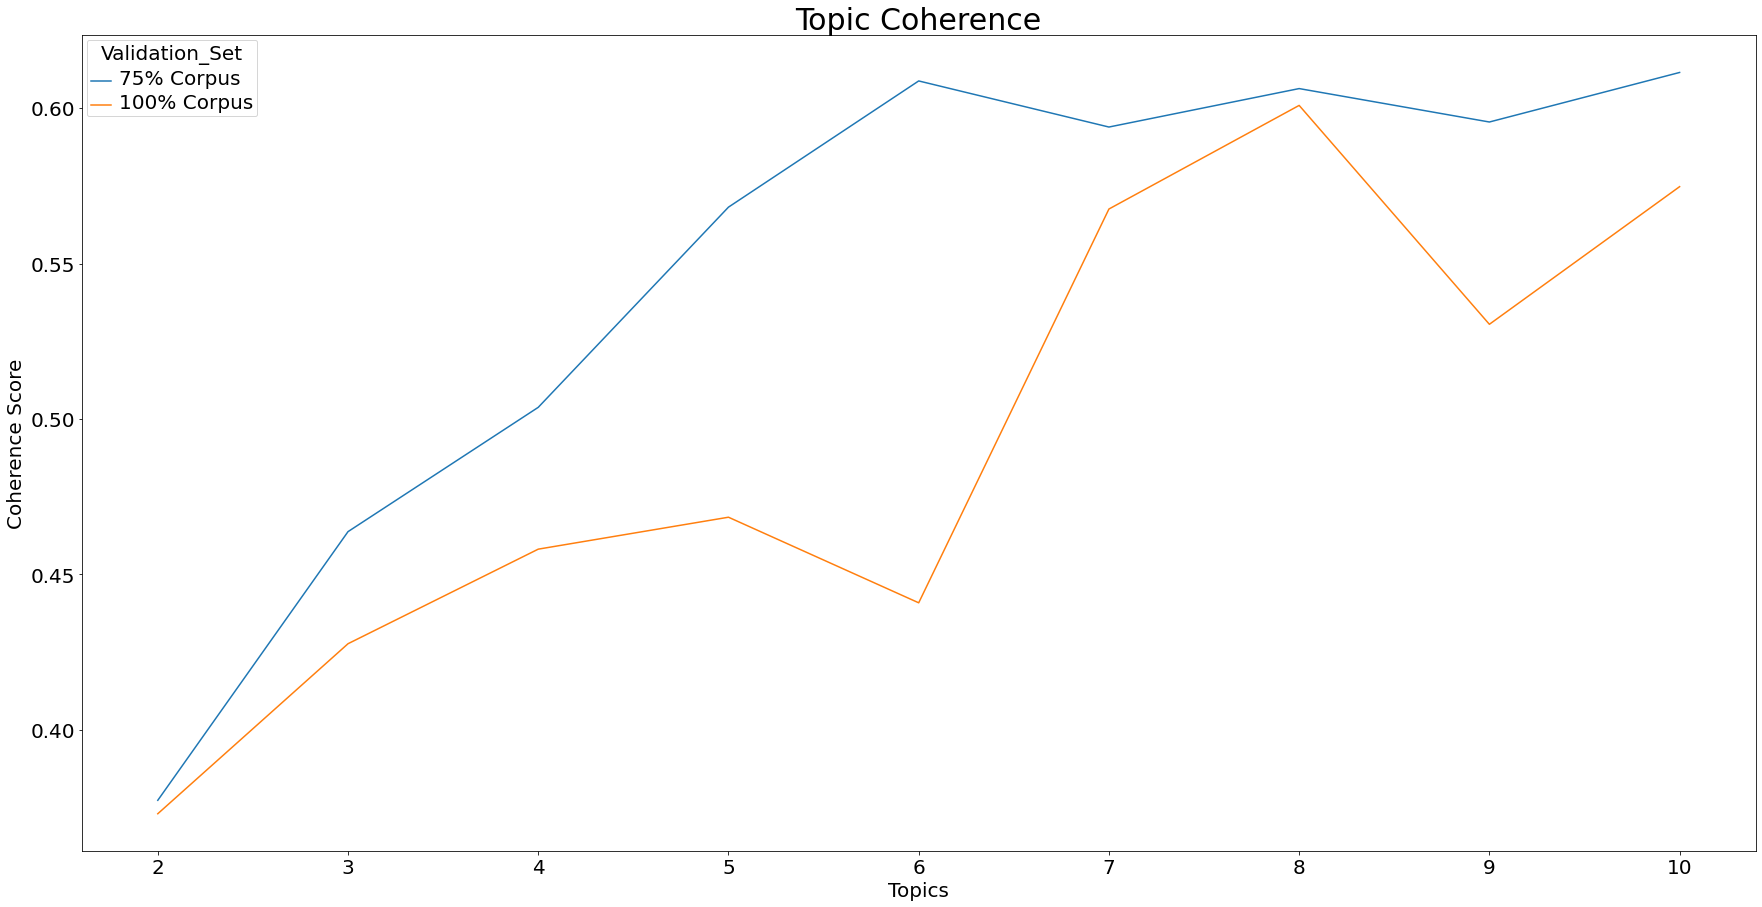

In [18]:
alpha_val = (lda_result.Alpha == "asymmetric")
beta_val = (lda_result.Beta == "0.9099999999999999")

lda_sample = lda_result[alpha_val & beta_val]

plt.rcParams['figure.figsize'] = [30,15]

lp = sns.lineplot(data=lda_sample, x="Topics", y="Coherence", hue="Validation_Set")
lp.axes.set_title("Topic Coherence", fontsize=30)
lp.set_xlabel("Topics", fontsize=20)
lp.set_ylabel("Coherence Score", fontsize=20)
lp.tick_params(labelsize=20, axis='x')
lp.tick_params(labelsize=20, axis='y')
plt.setp(lp.get_legend().get_texts(), fontsize=20)
plt.setp(lp.get_legend().get_title(), fontsize=20)

plt.show()

Based on the visualization above, the validation set of 75% corpus is superior to full validatin set. Let's focus on the 75% validation set, the plot is linearly increasing and notice that the topic at 6 to 10 shows a constant coherence score but eventually topic 10 still has the highest score. 

Given that the base model gives a score of 0.37, the model with hyperparameter tuning yields approximately <b>60%</b> improvement over the base model score with parameter set at 10 topics, asymmetric alpha value, 0.9 beta value and 75% validation set.

### Final Model

In [11]:
lda_final = models.LdaModel(corpus=corpus_new, 
                            num_topics=10, 
                            id2word=id2word, 
                            passes=10, 
                            random_state=100,
                            chunksize=100,   
                            alpha="asymmetric",    
                            eta=0.9099999999999999)
lda_final.print_topics()

[(0,
  '0.058*"time" + 0.034*"way" + 0.027*"year" + 0.017*"work" + 0.015*"point" + 0.015*"friend" + 0.014*"reason" + 0.014*"man" + 0.013*"world" + 0.011*"job"'),
 (1,
  '0.066*"game" + 0.026*"player" + 0.024*"part" + 0.020*"place" + 0.018*"guy" + 0.016*"kid" + 0.013*"child" + 0.012*"d" + 0.010*"play" + 0.010*"damage"'),
 (2,
  '0.034*"life" + 0.029*"money" + 0.019*"story" + 0.018*"country" + 0.017*"example" + 0.017*"need" + 0.015*"company" + 0.012*"state" + 0.011*"amount" + 0.011*"type"'),
 (3,
  '0.107*"thing" + 0.060*"lot" + 0.058*"day" + 0.026*"use" + 0.025*"problem" + 0.023*"case" + 0.020*"other" + 0.016*"car" + 0.012*"control" + 0.011*"show"'),
 (4,
  '0.050*"post" + 0.036*"question" + 0.028*"comment" + 0.023*"action" + 0.022*"woman" + 0.021*"gt" + 0.021*"issue" + 0.021*"rule" + 0.016*"submission" + 0.015*"content"'),
 (5,
  '0.188*"people" + 0.032*"system" + 0.022*"end" + 0.016*"body" + 0.015*"music" + 0.014*"water" + 0.014*"feeling" + 0.013*"argument" + 0.011*"house" + 0.011*"en

#### LDA Visualization
**Documentation of pyLDAvis: https://pyldavis.readthedocs.io/en/latest/readme.html#:~:text=pyLDAvis%20is%20designed%20to%20help,an%20interactive%20web%2Dbased%20visualization.

In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_final, corpus_new, id2word)
LDAvis_prepared

C:\Users\nicho\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034257 -0.281779       1        1  23.834966
1     -0.042419 -0.105320       2        1  15.199903
2      0.012234 -0.063462       3        1  11.792886
4      0.363777  0.024807       4        1  10.552052
3     -0.035812  0.054872       5        1  10.004716
5     -0.038267  0.010758       6        1   8.105796
7     -0.072012  0.068075       7        1   5.650150
6     -0.037610  0.088627       8        1   5.439164
9     -0.049028  0.102001       9        1   4.864670
8     -0.066606  0.101420      10        1   4.555697, topic_info=         Term         Freq        Total Category  logprob  loglift
199    people  3522.000000  3522.000000  Default  30.0000  30.0000
33      thing  2483.000000  2483.000000  Default  29.0000  29.0000
67       time  3223.000000  3223.000000  Default  28.0000  28.0000
19       game  2334.000000  2334.000000  Default  27.0000  27.0000
91        lot  1399.000000  1399.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1019      dps    44.645064    52.909140  Topic10  -5.4636   2.9190
1029   planet    54.085753    67.126571  Topic10  -5.2718   2.8728
3058    trick    43.445836    52.456905  Topic10  -5.4909   2.9003
2787  fantasy    51.175819    69.602289  Topic10  -5.3271   2.7813
488       gas    43.554563    72.629114  Topic10  -5.4884   2.5774

[427 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1449      1  0.003265  ability
1449      2  0.979511  ability
1449      5  0.003265  ability
1449      6  0.003265  ability
1449      9  0.003265  ability
...     ...       ...      ...
906       9  0.898145    worry
111       1  0.995463     year
111       2  0.000674     year
111       3  0.002021     year
111       5  0.000674     year

[1898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6, 8, 7, 10, 9])

### Make Topic Prediction 

In [91]:
predict_text = pd.DataFrame({'text':["The game was played in an internet web. I forgot the gameplay, but all character are worm. They kinda form a band. I remember the name was something like 'Maple Story'."]})
corpus_predict = [id2word.doc2bow(text) for text in predict_text.text.str.split()]
predict_model = sorted(lda_final[corpus_predict][0], key=lambda tup: tup[1], reverse=True)
predict_topic = predict_model[0][0]
print("The topic of the document belong to Topic", predict_topic, "consist of:\n", lda_final.print_topics()[predict_topic][1])

The topic of the document belong to Topic 1 consist of:
 0.066*"game" + 0.026*"player" + 0.024*"part" + 0.020*"place" + 0.018*"guy" + 0.016*"kid" + 0.013*"child" + 0.012*"d" + 0.010*"play" + 0.010*"damage"
